In [1]:
!pip install torch torchvision torchaudio accelerate datasets transformers scikit-learn matplotlib pandas numpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
#import torch.nn as nn
#import accelerate
from datasets import load_dataset

from sklearn.metrics import accuracy_score, f1_score
from collections import Counter

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, pipeline

from peft import LoraConfig, get_peft_model, TaskType

import os
os.environ["WANDB_DISABLED"] = "true"

In [3]:
# Check if GPU is available, becouse training on CPU is very slow!!!
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla T4


In [4]:
dataset = load_dataset("go_emotions")

emotions = dataset["train"].features["labels"].feature.names
num_labels = len(emotions)
print(len(dataset["train"]))
print(num_labels)
print(emotions)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

43410
28
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [5]:
# Get the distribution of emotions in the dataset
emotion_counter = Counter()

for split, split_data in dataset.items():
    for sample in split_data:
        emotion_counter.update(sample["labels"])

emotions_count = {emotion: emotion_counter.get(i, 0) for i, emotion in enumerate(emotions)}

print(emotions_count)

{'admiration': 5122, 'amusement': 2895, 'anger': 1960, 'annoyance': 3093, 'approval': 3687, 'caring': 1375, 'confusion': 1673, 'curiosity': 2723, 'desire': 801, 'disappointment': 1583, 'disapproval': 2581, 'disgust': 1013, 'embarrassment': 375, 'excitement': 1052, 'fear': 764, 'gratitude': 3372, 'grief': 96, 'joy': 1785, 'love': 2576, 'nervousness': 208, 'optimism': 1976, 'pride': 142, 'realization': 1382, 'relief': 182, 'remorse': 669, 'sadness': 1625, 'surprise': 1330, 'neutral': 17772}


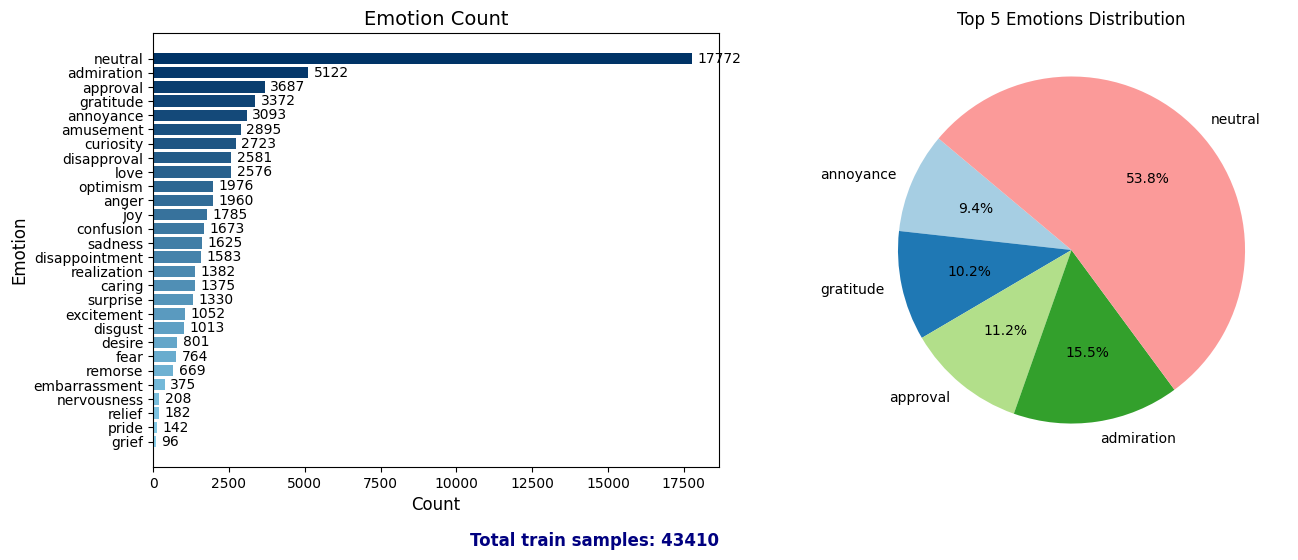

In [6]:
# --- Sort by ascending count ---
sorted_items = sorted(emotions_count.items(), key=lambda x: x[1])
emotions_sorted, counts_sorted = zip(*sorted_items)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Horizontal bar plot (left) ---
import matplotlib.colors as mcolors

# Create a colormap from darkblue to lightblue
cmap = mcolors.LinearSegmentedColormap.from_list("blue_gradient", ["#87CEEB", "#003366"])
# Generate colors from the colormap for each bar
colors = [cmap(i / (len(emotions_sorted) - 1)) for i in range(len(emotions_sorted))]
bars = axes[0].barh(emotions_sorted, counts_sorted, color=colors)
for bar, count in zip(bars, counts_sorted):
    axes[0].text(
        bar.get_width() + max(counts_sorted) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight='normal'
    )
axes[0].set_xlabel("Count", fontsize=12)
axes[0].set_ylabel("Emotion", fontsize=12)
axes[0].set_title("Emotion Count", fontsize=14)

# Show total train data at the bottom right
axes[0].text(
    1.0, -0.15, f"Total train samples: {len(dataset['train'])}",
    transform=axes[0].transAxes,
    fontsize=12,
    color="navy",
    ha="right",
    va="top",
    fontweight="bold"
)

# --- Pie chart of top 5 emotions (right) ---
top5_emotions = emotions_sorted[-5:]
top5_counts = counts_sorted[-5:]
axes[1].pie(top5_counts, labels=top5_emotions, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors[:5])
axes[1].set_title("Top 5 Emotions Distribution")

plt.tight_layout(pad=2)
plt.show()


In [7]:
def multi_hot_encode(samples):
    multi_hot = np.zeros(len(emotions))

    for label in samples["labels"]:
        multi_hot[label] = 1

    return {"labels": multi_hot.tolist()}

dataset = dataset.map(multi_hot_encode)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [8]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format of the dataset to PyTorch tensors
tokenized_dataset.set_format("torch")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [9]:
convert_to_float = lambda sample: {"float_labels": sample["labels"].to(torch.float)}

tokenized_dataset = (tokenized_dataset
                     .map(convert_to_float, remove_columns=["labels"])
                     .rename_column("float_labels", "labels"))

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [10]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(emotions),
    problem_type="multi_label_classification"
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
model = model.to(device)

cuda:0


In [12]:
# Define parameters
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
EPOCHS = 5
WEIGHT_DECAY = 1e-2

In [13]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    fp16=True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [14]:
def compute_metrics(pred):
    logits, labels = pred
    preds = (logits > 0.5).astype(int) # Convert probabilities to binary predictions

    f1 = f1_score(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)

    return {
        'f1': f1,
        'accuracy': acc
    }

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.099000,0.092287,0.429033,0.284740
2,0.082200,0.084322,0.503647,0.362882
3,0.069000,0.084496,0.539935,0.407482
4,0.062400,0.087721,0.550580,0.420936
5,0.054700,0.089687,0.558910,0.441946


TrainOutput(global_step=13570, training_loss=0.08013967981036305, metrics={'train_runtime': 2023.2431, 'train_samples_per_second': 107.278, 'train_steps_per_second': 6.707, 'total_flos': 1.42803965293056e+16, 'train_loss': 0.08013967981036305, 'epoch': 5.0})

In [17]:
multilabel_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,  # return all pedictions first
)

Device set to use cuda:0


In [18]:
#result = multilabel_pipeline("I simply can't stand when my computer freezes")
#result = multilabel_pipeline("I hate you, but i also like you")
result = multilabel_pipeline("I’m Not Mad")
result

[[{'label': 'LABEL_27', 'score': 0.8333246111869812},
  {'label': 'LABEL_10', 'score': 0.07396337389945984},
  {'label': 'LABEL_3', 'score': 0.04778006672859192},
  {'label': 'LABEL_4', 'score': 0.026759279891848564},
  {'label': 'LABEL_2', 'score': 0.012970387004315853},
  {'label': 'LABEL_22', 'score': 0.0060975621454417706},
  {'label': 'LABEL_5', 'score': 0.0035380858462303877},
  {'label': 'LABEL_9', 'score': 0.003469890682026744},
  {'label': 'LABEL_20', 'score': 0.002387409098446369},
  {'label': 'LABEL_0', 'score': 0.0017961491830646992},
  {'label': 'LABEL_6', 'score': 0.0012893284438177943},
  {'label': 'LABEL_11', 'score': 0.0012497095158323646},
  {'label': 'LABEL_8', 'score': 0.001220795209519565},
  {'label': 'LABEL_26', 'score': 0.0009253848693333566},
  {'label': 'LABEL_17', 'score': 0.0008295890875160694},
  {'label': 'LABEL_13', 'score': 0.0007978335488587618},
  {'label': 'LABEL_25', 'score': 0.0007264874875545502},
  {'label': 'LABEL_7', 'score': 0.00066410482395440

In [19]:
def get_emotion(pred):
    """
    Gets the int number after the _ in "LABEL_X"
    e.g.: LABEL_18 yields just the integer 18
    We use this integer as index to get the original emotion name
    """
    pred_emotion_idx = int(pred["label"].split('_')[1])
    return emotions[pred_emotion_idx]

predicted_emotions = [get_emotion(pred) for pred in result[0] if pred["score"] > 0.1]
predicted_emotions

['neutral']

In [20]:
# === Per-label threshold search (validation) and test evaluation ===
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score

def _sigmoid(x): return 1 / (1 + np.exp(-x))

def _predict_split(trainer, split_ds):
    out = trainer.predict(split_ds)
    y_true = out.label_ids
    y_score = _sigmoid(out.predictions)
    if y_score.ndim == 1: y_score = y_score.reshape(-1, 1)
    return y_true, y_score

# 1) Get validation scores
y_true_val, y_score_val = _predict_split(trainer, tokenized_dataset["validation"])
L = y_true_val.shape[1]
if "label_names" not in globals():
    label_names = [f"L{i}" for i in range(L)]

# 2) Grid-search a separate threshold for each label
grid = np.round(np.arange(0.05, 0.95 + 1e-9, 0.01), 2)
best_thr_per_label = np.zeros(L)
best_f1_per_label  = np.zeros(L)

for j in range(L):
    yj_true  = y_true_val[:, j]
    yj_score = y_score_val[:, j]
    best_f1, best_t = -1, 0.5
    for t in grid:
        yj_pred = (yj_score >= t).astype(int)
        f1 = f1_score(yj_true, yj_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    best_thr_per_label[j] = best_t
    best_f1_per_label[j]  = best_f1

thr_table = pd.DataFrame({
    "label": label_names,
    "best_thr": best_thr_per_label,
    "val_f1_at_best_thr": best_f1_per_label
}).sort_values("val_f1_at_best_thr", ascending=False).reset_index(drop=True)
display(thr_table.head(15))

# 3) Evaluate on TEST using per-label thresholds
y_true_test, y_score_test = _predict_split(trainer, tokenized_dataset["test"])
y_pred_test = (y_score_test >= best_thr_per_label[None, :]).astype(int)

# Summary metrics
subset_acc = accuracy_score(y_true_test, y_pred_test)
micro_f1   = f1_score(y_true_test, y_pred_test, average="micro", zero_division=0)
macro_f1   = f1_score(y_true_test, y_pred_test, average="macro", zero_division=0)
samples_f1 = f1_score(y_true_test, y_pred_test, average="samples", zero_division=0)

print("=== TEST (per-label thresholds) ===")
print(f"subset_accuracy: {subset_acc:.4f}")
print(f"micro_f1:       {micro_f1:.4f}")
print(f"macro_f1:       {macro_f1:.4f}")
print(f"samples_f1:     {samples_f1:.4f}")

# Per-label breakdown
p, r, f, s = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)
per_label = pd.DataFrame({
    "label": label_names, "precision": p, "recall": r, "f1": f, "support": s, "thr_used": best_thr_per_label
}).sort_values("support", ascending=False).reset_index(drop=True)
display(per_label.head(20))


,label,best_thr,val_f1_at_best_thr
0,L15,0.77,0.916545
1,L1,0.24,0.806647
2,L18,0.30,0.781086
3,L24,0.20,0.770270
4,L0,0.51,0.742798
5,L27,0.17,0.670870
6,L14,0.09,0.657277
7,L20,0.29,0.594340
8,L17,0.26,0.587912
9,L21,0.06,0.583333


=== TEST (per-label thresholds) ===
subset_accuracy: 0.4295
micro_f1:       0.6018
macro_f1:       0.5115
samples_f1:     0.6165


,label,precision,recall,f1,support,thr_used
0,L27,0.610915,0.776721,0.683912,1787,0.17
1,L0,0.696429,0.696429,0.696429,504,0.51
2,L15,0.962382,0.872159,0.915052,352,0.77
3,L4,0.376559,0.430199,0.401596,351,0.32
4,L3,0.318807,0.434375,0.367725,320,0.26
5,L7,0.456914,0.802817,0.582375,284,0.17
6,L10,0.409524,0.483146,0.443299,267,0.33
7,L1,0.746082,0.901515,0.816467,264,0.24
8,L18,0.733096,0.865546,0.793834,238,0.30
9,L2,0.502347,0.540404,0.520681,198,0.32


In [21]:
# === Surface interesting errors on TEST ===
import pandas as pd
import numpy as np

# Ensure we have y_true_test/y_score_test/y_pred_test from A1 cell; otherwise recompute
if 'y_true_test' not in globals() or 'y_pred_test' not in globals():
    y_true_test, y_score_test = _predict_split(trainer, tokenized_dataset["test"])
    y_pred_test = (y_score_test >= 0.5).astype(int)

texts_test = tokenized_dataset["test"]["text"]

def labels_to_str(row):
    return ", ".join(np.array(label_names)[np.where(row==1)[0]])

df_err = pd.DataFrame({
    "text": texts_test,
    "true": [labels_to_str(y_true_test[i]) for i in range(len(texts_test))],
    "pred": [labels_to_str(y_pred_test[i]) for i in range(len(texts_test))]
})
df_err = df_err[df_err["true"] != df_err["pred"]]

print("Total misclassified samples:", len(df_err))
display(df_err.sample(8, random_state=42))


Total misclassified samples: 3096


,text,true,pred
3416,Fair enough. I considered it malicious complia...,L27,L4
2335,"Wow, your ex partner sounds exactly like mine.",L22,L26
2838,"Yeah, that one. I forgot the name earlier.",L27,"L22, L27"
4616,Why did we have [NAME] that one year shoot aga...,L6,"L6, L7, L27"
4270,> This is just a waste of time. Just like maki...,"L9, L10","L3, L10"
3437,Analytics and instagram... are you joking?,"L6, L27","L1, L7"
4768,The best ever you are the [NAME]!!,L27,L0
344,"Probably, I knew this lawn chair was a bad idea.",L10,"L9, L22"


In [22]:
# === Best & worst labels by F1 (TEST) ===
from sklearn.metrics import precision_recall_fscore_support

p, r, f, s = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)
table = pd.DataFrame({"label": label_names, "precision": p, "recall": r, "f1": f, "support": s})
best5  = table.sort_values("f1", ascending=False).head(5)
worst5 = table.sort_values("f1", ascending=True).head(5)
print("Top-5 labels by F1:")
display(best5)
print("Bottom-5 labels by F1:")
display(worst5)


Top-5 labels by F1:


,label,precision,recall,f1,support
15,L15,0.962382,0.872159,0.915052,352
1,L1,0.746082,0.901515,0.816467,264
18,L18,0.733096,0.865546,0.793834,238
0,L0,0.696429,0.696429,0.696429,504
27,L27,0.610915,0.776721,0.683912,1787


Bottom-5 labels by F1:


,label,precision,recall,f1,support
16,L16,0.000000,0.000000,0.000000,6
22,L22,0.252101,0.206897,0.227273,145
21,L21,0.571429,0.250000,0.347826,16
9,L9,0.314433,0.403974,0.353623,151
3,L3,0.318807,0.434375,0.367725,320


<Figure size 640x480 with 0 Axes>

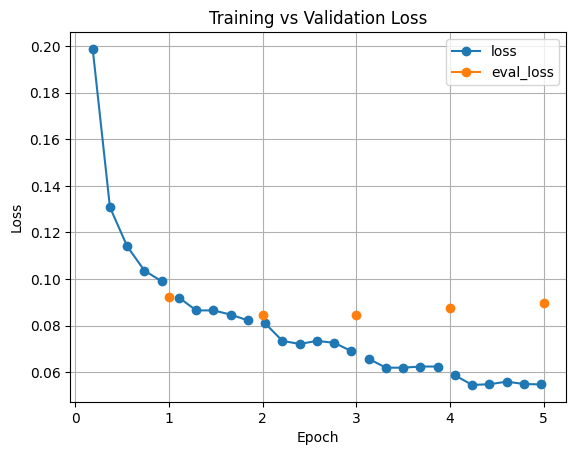

In [23]:
# === Plot learning curves from Trainer logs ===
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)
# Keep useful keys only
keys = ["epoch", "loss", "eval_loss", "eval_f1", "eval_accuracy"]
curves = logs[[k for k in keys if k in logs.columns]].dropna(how="all")

# Loss curve
plt.figure()
curves.plot(x="epoch", y=[c for c in ["loss","eval_loss"] if c in curves.columns], marker="o")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()




In [24]:
# === Efficiency snapshot ===
import torch, numpy as np, pandas as pd

def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

total_p, trainable_p = count_params(model)
runtime_sec = float(getattr(trainer.state, "train_runtime", np.nan))
steps_per_sec = float(getattr(trainer.state, "train_steps_per_second", np.nan))
samples_per_sec = float(getattr(trainer.state, "train_samples_per_second", np.nan))

try:
    vram_mb = torch.cuda.max_memory_allocated() / (1024**2)
except:
    vram_mb = np.nan

eff = pd.DataFrame([{
    "strategy": "current_model",
    "total_params": total_p,
    "trainable_params": trainable_p,
    "train_runtime_s": runtime_sec,
    "steps_per_s": steps_per_sec,
    "samples_per_s": samples_per_sec,
    "approx_max_VRAM_MB": vram_mb
}])
display(eff)


,strategy,total_params,trainable_params,train_runtime_s,steps_per_s,samples_per_s,approx_max_VRAM_MB
0,current_model,109503772,109503772,NaN,NaN,NaN,2297.915039


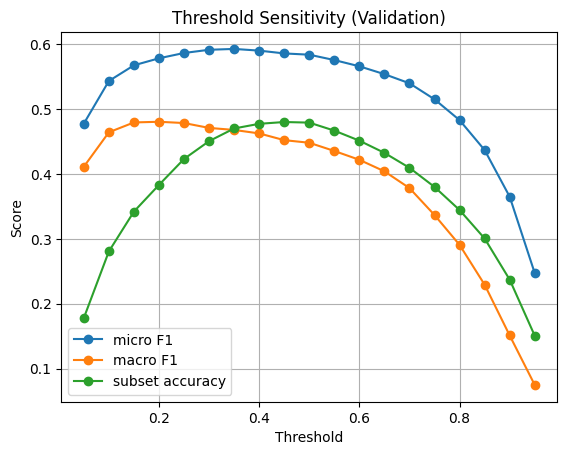

In [25]:
# === Single-threshold sensitivity (VAL) ===
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

y_true_val, y_score_val = _predict_split(trainer, tokenized_dataset["validation"])
ths = np.linspace(0.05, 0.95, 19)
micro_f1s, macros, accs = [], [], []

for t in ths:
    y_pred = (y_score_val >= t).astype(int)
    micro_f1s.append(f1_score(y_true_val, y_pred, average="micro", zero_division=0))
    macros.append(f1_score(y_true_val, y_pred, average="macro", zero_division=0))
    accs.append(accuracy_score(y_true_val, y_pred))

plt.figure()
plt.plot(ths, micro_f1s, marker="o", label="micro F1")
plt.plot(ths, macros, marker="o", label="macro F1")
plt.plot(ths, accs, marker="o", label="subset accuracy")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Sensitivity (Validation)")
plt.grid(True)
plt.legend()
plt.show()
